In [1]:
using DelaySSAToolkit
using Catalyst
using Statistics
using Test
using BenchmarkTools
using Symbolics

A birth-death example with delay degradation is defined as follows:
$$
\begin{aligned}
&\emptyset \xrightarrow{C} X_A, \\
&X_A \xrightarrow{\gamma} \emptyset,\\
&X_A \xrightarrow{\beta}  X_I, \text{ which triggers  } X_I\Rightarrow \emptyset \text{ after delay } \tau,\\
&X_I \xrightarrow{\gamma} \emptyset.  
\end{aligned}
$$
Notice that the last reaction $X_I \xrightarrow{\gamma} \emptyset$ causes the delay channel to change its state during a scheduled delay reaction.

In [2]:
using DiffEqJump, Catalyst, DelaySSAToolkit
rn = @reaction_network begin
   C, 0 --> Xₐ
   γ, Xₐ --> 0
   β, Xₐ --> Xᵢ
   γ, Xᵢ --> 0
end C γ β
jumpsys = convert(JumpSystem, rn, combinatoric_ratelaws = false);

In [3]:
u0 = [0, 0]
tf = 30.
saveat = .1
C, γ, β = [2., 0.1, 0.5]
p = [C, γ, β]
tspan = (0.,tf)
dprob = DiscreteProblem(u0, tspan, p);

In [6]:
τ = 15.
delay_trigger_affect! = function (integrator, rng)
   append!(integrator.de_chan[1], τ)
end
delay_trigger = Dict(3=>delay_trigger_affect!)
delay_complete = Dict(1=>[2=>-1]) 
delay_affect! = function (integrator, rng)
    i = rand(rng, 1:length(integrator.de_chan[1]))
    deleteat!(integrator.de_chan[1],i)
end
delay_interrupt = Dict(4=>delay_affect!) 
delayjumpset = DelayJumpSet(delay_trigger,delay_complete,delay_interrupt)
de_chan0 = [[]];

In [ ]:
medianlist=[]
algo_list =[DelayDirect(),DelayRejection(),DelayMNRM(),DelayDirectCR()]
for algo in algo_list
    djprob = DelayJumpProblem(jumpsys,dprob,algo,delayjumpset, de_chan0, save_positions=(false,false))
    bm = @benchmark solve($djprob, SSAStepper())
    push!(medianlist,copy(median(bm).time/1e9))
end;

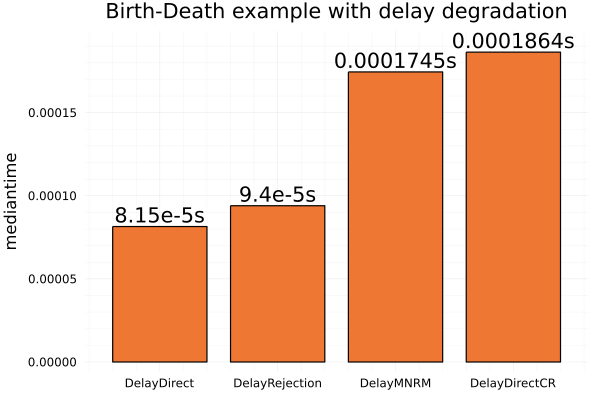

In [9]:
using Plots; theme(:vibrant)
medianvalue=[string(round(mt,digits=7),"s") for mt in medianlist]
algo_name = ["DelayDirect","DelayRejection","DelayMNRM","DelayDirectCR"]
bar(algo_name,medianlist,legend=:false,title="Birth-Death example with delay degradation",ylabel="mediantime")
scatter!(algo_name, 7e-6 .+ medianlist , markeralpha=0,series_annotations=medianvalue)